In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
from collections import Counter
#import pymysql
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv('./Emo_data/total_emotion_data.csv', encoding='utf-8')

In [4]:
data = data[['Text', 'Emotion']]
data

,Text,Emotion
0,thank yeah nice thought sheltered happy worrie...,1
1,feel like craving matter order really impressed,1
2,saw red audi highway sped uo hoping loss,1
3,happy hand matches followed cuffs,1
4,even confronted overwhelming evidence doubled man,1
...,...,...
26313,wan na controversial streak might end,2
26314,twilight still better love story last jedi,2
26315,section tate museum amazing,2
26316,fantastic combover brand comb use,2


In [5]:
data['Emotion'].value_counts()

6    4535
4    4529
3    4446
2    4412
5    4322
1    4074
Name: Emotion, dtype: int64

In [6]:
# 1부터 시작하는 감정들을 0부터 시작
data['Emotion'] = data['Emotion'].map(lambda x : x - 1)

In [7]:
import text_hammer as th

In [8]:
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()

def text_preprocessing(df,col_name):
    column = col_name
    df[column] = df[column].progress_apply(lambda x:str(x).lower())
    df[column] = df[column].progress_apply(lambda x: th.cont_exp(x)) #you're -> you are; i'm -> i am
    df[column] = df[column].progress_apply(lambda x: th.remove_emails(x))
#     df[column] = df[column].progress_apply(lambda x: th.remove_html_tags(x))
#     df[column] = df[column].progress_apply(lambda x: ps.remove_stopwords(x))

    df[column] = df[column].progress_apply(lambda x: th.remove_special_chars(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_accented_chars(x))
#     df[column] = df[column].progress_apply(lambda x: th.make_base(x)) #ran -> run,
    return(df)

In [9]:
df_cleaned = text_preprocessing(data,'Text')

  0%|          | 0/26318 [00:00<?, ?it/s]

  0%|          | 0/26318 [00:00<?, ?it/s]

  0%|          | 0/26318 [00:00<?, ?it/s]

  0%|          | 0/26318 [00:00<?, ?it/s]

  0%|          | 0/26318 [00:00<?, ?it/s]

In [10]:
df_cleaned = df_cleaned.copy()

In [11]:
df_cleaned['Emotion'] = df_cleaned['Emotion'].astype('int') 

In [12]:
df_cleaned

,Text,Emotion
0,thank yeah nice thought sheltered happy worrie...,0
1,feel like craving matter order really impressed,0
2,saw red audi highway sped uo hoping loss,0
3,happy hand matches followed cuffs,0
4,even confronted overwhelming evidence doubled man,0
...,...,...
26313,wan na controversial streak might end,1
26314,twilight still better love story last jedi,1
26315,section tate museum amazing,1
26316,fantastic combover brand comb use,1


In [13]:
from sklearn.model_selection import train_test_split
data_train,data_test = train_test_split(df_cleaned, test_size = 0.3, random_state = 42, stratify = df_cleaned.Emotion)

In [14]:
data_test

,Text,Emotion
2432,uuuuugh keeps penis spitting,0
20745,would like pay anything,4
6691,shamefull unequal dangerous worrying world liv...,5
21548,hated keep watching every character personal j...,4
23844,hey get point view appreciate explanation,1
...,...,...
5023,crazy kids nap think heat still tell go grandm...,5
22300,pretty sure would punch someone,1
18123,der maaaaster back,4
20108,jchervinsky important message fredwilson new y...,4


In [15]:
from transformers import AutoTokenizer,TFBertModel
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
bert = TFBertModel.from_pretrained('bert-base-cased')

2023-04-16 04:26:22.409764: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-16 04:26:24.842669: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-16 04:26:24.869455: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-16 04:26:24.869779: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there m

In [16]:
tokenizer.save_pretrained('bert-tokenizer')
bert.save_pretrained('bert-model')

In [17]:
from transformers import BertTokenizer, TFBertModel, BertConfig,TFDistilBertModel,DistilBertTokenizer,DistilBertConfig
dbert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['activation_13', 'vocab_projector', 'vocab_layer_norm', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [18]:
x_train = tokenizer(
    text=data_train.Text.tolist(),
    add_special_tokens=True,
    max_length=70,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)


x_test = tokenizer(
    text=data_test.Text.tolist(),
    add_special_tokens=True,
    max_length=70,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

In [19]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical

In [20]:
max_len = 70
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense

input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
input_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")
# embeddings = dbert_model(input_ids,attention_mask = input_mask)[0]


embeddings = bert(input_ids,attention_mask = input_mask)[0] #(0 is the last hidden states,1 means pooler_output)
out = tf.keras.layers.GlobalMaxPool1D()(embeddings)
out = Dense(128, activation='relu')(out)
out = tf.keras.layers.Dropout(0.1)(out)
out = Dense(32,activation = 'relu')(out)

y = Dense(6,activation = 'sigmoid')(out)
model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=y)
model.layers[2].trainable = True
# for training bert our lr must be so small

In [21]:
optimizer = tf.keras.optimizers.legacy.Adam(
    learning_rate=5e-05, # this learning rate is for bert model , taken from huggingface website 
    epsilon=1e-08,
    decay=0.01,
    clipnorm=1.0)

# Set loss and metrics
loss =CategoricalCrossentropy(from_logits = True)
metric = CategoricalAccuracy('balanced_accuracy'),
# Compile the model
model.compile(
    optimizer = optimizer,
    loss = loss, 
    metrics = metric)

In [22]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 70)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 70)]         0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 70,                                            

In [23]:
tf.config.experimental_run_functions_eagerly(True)
tf.config.run_functions_eagerly(True)

Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


In [39]:
train_history = model.fit(
    x ={'input_ids':x_train['input_ids'],'attention_mask':x_train['attention_mask']} ,
    y = to_categorical(data_train.Emotion),
    validation_data = (
    {'input_ids':x_test['input_ids'],'attention_mask':x_test['attention_mask']}, to_categorical(data_test.Emotion)),
    epochs=20,
    batch_size=64
)

Epoch 1/20
288/288 [==============================] - 189s 656ms/step - loss: 0.6372 - balanced_accuracy: 0.7707 - val_loss: 1.9476 - val_balanced_accuracy: 0.4366
Epoch 2/20
288/288 [==============================] - 191s 662ms/step - loss: 0.6266 - balanced_accuracy: 0.7744 - val_loss: 1.9527 - val_balanced_accuracy: 0.4373
Epoch 3/20
288/288 [==============================] - 188s 654ms/step - loss: 0.6228 - balanced_accuracy: 0.7735 - val_loss: 1.9617 - val_balanced_accuracy: 0.4367
Epoch 4/20
288/288 [==============================] - 188s 652ms/step - loss: 0.6242 - balanced_accuracy: 0.7762 - val_loss: 1.9624 - val_balanced_accuracy: 0.4366
Epoch 5/20
288/288 [==============================] - 188s 654ms/step - loss: 0.6196 - balanced_accuracy: 0.7736 - val_loss: 1.9725 - val_balanced_accuracy: 0.4373
Epoch 6/20
288/288 [==============================] - 190s 661ms/step - loss: 0.6132 - balanced_accuracy: 0.7789 - val_loss: 1.9773 - val_balanced_accuracy: 0.4372
Epoch 7/20
288/2

In [41]:
model.save_weights('./multi_model_checkpoint/new_multi_sentiment_weights')

In [40]:
predicted_raw = model.predict({'input_ids':x_test['input_ids'],'attention_mask':x_test['attention_mask']})

247/247 [==============================] - 34s 136ms/step


In [42]:
predicted_raw[2]

array([0.09003849, 0.09933042, 0.0089325 , 0.06913669, 0.37549797,
       0.9991972 ], dtype=float32)

In [28]:
y_predicted = np.argmax(predicted_raw, axis = 1)

In [29]:
from sklearn.metrics import classification_report

In [30]:
print(classification_report(data_test.Emotion, y_predicted))

              precision    recall  f1-score   support

           0       0.46      0.38      0.41      1222
           1       0.41      0.39      0.40      1324
           2       0.48      0.53      0.50      1334
           3       0.51      0.55      0.53      1359
           4       0.33      0.38      0.35      1297
           5       0.44      0.39      0.42      1360

    accuracy                           0.44      7896
   macro avg       0.44      0.44      0.44      7896
weighted avg       0.44      0.44      0.44      7896



In [32]:
# 시각화
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

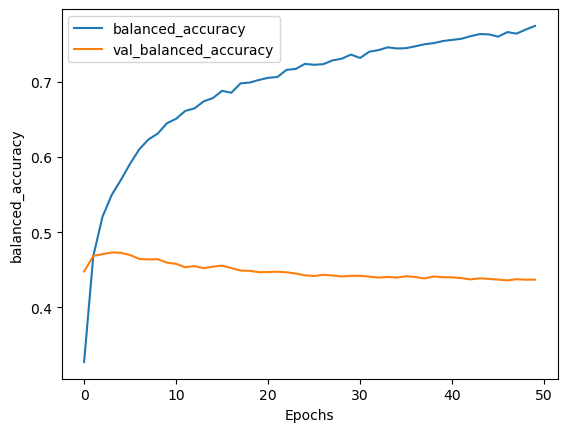

In [33]:
plot_graphs(train_history, 'balanced_accuracy')

In [34]:
def emotion_predict(sentence):
    x_val = tokenizer(
        text=sentence,
        add_special_tokens=True,
        max_length=70,
        truncation=True,
        padding='max_length', 
        return_tensors='tf',
        return_token_type_ids = False,
        return_attention_mask = True,
        verbose = True)
    emo_dic =  ['surprise', 'love', 'happy', 'sadness', 'anger', 'fear']
    validation = model.predict({'input_ids':x_val['input_ids'],'attention_mask':x_val['attention_mask']})[0].tolist()
    return {k:v for k,v in zip(emo_dic, validation)}

In [35]:
kisch_review = pd.read_csv('kitsch_eng_review.csv', index_col=None)
kitsch = kisch_review['0'].to_list()

In [36]:
kitsch

['Liz deserves more lines why is starship unfair to Liz',
 'what does it mean',
 'Can someone inform me what a kitsch is',
 'What a great song',
 'Full Album on April th',
 'A music video literally never angered me more I love these girls and it s no fault of them but what the label is doing to this group is so shameful Poor Liz got no screen time or lines in the song I repeatedly saw the same girls over and over in this video while she was hidden They couldn t try any harder to hide her It s horrible Someone pick this girl up under a new group so she can be allowed to shine I m so tired of certain girls in this group being so praised by the label while Liz is treated like a background character It s one thing for fandoms to have favorites but for a label to and make it so obvious is messed up It s not even like she s bad her voice is wonderful she s beautiful inside and out and her performance skills are great She knows how to do her job To be treated like a wall because you don t fit

In [37]:
from lyrics_preprocessing_en import sentence_preprocessing, lyrics_to_corpus

In [38]:
#my_list = []
for i in kitsch:
    print("%s :\n%s"%(i,emotion_predict(i)))
    #my_list.append(emotion_predict(i))
    #print(emotion_predict(i))

1/1 [==============================] - 0s 149ms/step
Liz deserves more lines why is starship unfair to Liz :
{'surprise': 0.04318663477897644, 'love': 0.16619433462619781, 'happy': 0.032242659479379654, 'sadness': 0.26468533277511597, 'anger': 0.41134822368621826, 'fear': 0.0823427215218544}
1/1 [==============================] - 0s 147ms/step
what does it mean :
{'surprise': 0.2508712708950043, 'love': 0.13191477954387665, 'happy': 0.060532476752996445, 'sadness': 0.09282806515693665, 'anger': 0.3139338195323944, 'fear': 0.14991964399814606}
1/1 [==============================] - 0s 145ms/step
Can someone inform me what a kitsch is :
{'surprise': 0.3044857084751129, 'love': 0.1266402006149292, 'happy': 0.08358893543481827, 'sadness': 0.06000564247369766, 'anger': 0.27309176325798035, 'fear': 0.1521877497434616}
1/1 [==============================] - 0s 161ms/step
What a great song :
{'surprise': 0.27321118116378784, 'love': 0.46938854455947876, 'happy': 0.1942923665046692, 'sadness': 

In [38]:
for i in kitsch:
    print("%s :\n%s"%(i,emotion_predict(i)))

1/1 [==============================] - 0s 164ms/step
Liz deserves more lines why is starship unfair to Liz :
{'surprise': 0.5508613586425781, 'love': 0.20235615968704224, 'happy': 0.08630473166704178, 'sadness': 0.9369282126426697, 'anger': 0.8727790713310242, 'fear': 0.7036412954330444}
1/1 [==============================] - 0s 218ms/step
what does it mean :
{'surprise': 0.7945908904075623, 'love': 0.3404965400695801, 'happy': 0.15897370874881744, 'sadness': 0.47927093505859375, 'anger': 0.6755079627037048, 'fear': 0.6777811646461487}
1/1 [==============================] - 0s 223ms/step
Can someone inform me what a kitsch is :
{'surprise': 0.970923125743866, 'love': 0.336325466632843, 'happy': 0.7503587007522583, 'sadness': 0.09909027069807053, 'anger': 0.8885282874107361, 'fear': 0.2841774821281433}
1/1 [==============================] - 0s 196ms/step
What a great song :
{'surprise': 0.9873499274253845, 'love': 0.9835016131401062, 'happy': 0.9410772323608398, 'sadness': 0.10553536564